In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import h5py

from IPython.display import clear_output
from datetime import datetime
from os import system, getcwd
from time import sleep
import threading
import webbrowser

%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 4)

python_path = "C:\\ProgramData\\Anaconda3\\envs\\tensorflow\\python.exe"
tensorboard_path = "C:\\ProgramData\\Anaconda3\\envs\\tensorflow\\Lib\\site-packages\\tensorboard\\main.py"
log_dir = getcwd() + "\\models"

In [2]:
def show_images():
    for i in range(24):
        plt.subplot(4,6,i+1)
        plt.imshow(train_x[i,:,:], cmap = "gray")
        plt.axis("off")
    plt.show()
    return

In [3]:
def load_sample_dataset():
    with  h5py.File("train_test_file_list.h5", "r") as hf:
        train_x = np.reshape(np.array(hf.get("train_x")), (-1, 784))
        train_y = np.eye(10)[np.reshape(np.array(hf.get("train_y")), -1)]
        test_x = np.reshape(np.array(hf.get("test_x")), (-1, 784))
        test_y = np.eye(10)[np.reshape(np.array(hf.get("test_y")), -1)]
    return train_x, train_y, test_x, test_y

In [4]:
train_x, train_y, test_x, test_y = load_sample_dataset()

In [5]:
for i in range(train_x.shape[0]):
    train_x[i,:] -= np.mean(train_x[i,:])
    train_x[i,:] /= np.std(train_x[i,:])

In [6]:
for i in range(test_x.shape[0]):
    test_x[i,:] -= np.mean(test_x[i,:])
    test_x[i,:] /= np.std(test_x[i,:])

In [7]:
sess = tf.Session()

x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

feed_dict = {x : train_x, y : train_y}
ds = tf.data.Dataset.from_tensor_slices((x, y))
batched_ds = ds.batch(256)
iterator = batched_ds.make_initializable_iterator()
next_x, next_y = iterator.get_next()

logits = next_x @ W + b
model = tf.nn.softmax(logits)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = next_y, logits = logits))
tf.summary.scalar("cross_entropy", cross_entropy)

global_step = tf.Variable(0, name = "global_step", trainable = False)
step_size = tf.Variable(0.1)
train = tf.train.AdamOptimizer(step_size).minimize(cross_entropy, global_step = global_step)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(model,1), tf.argmax(next_y,1)), tf.float32))
tf.summary.scalar("accuracy", accuracy)

merged = tf.summary.merge_all()
writer = tf.summary.FileWriter(log_dir, sess.graph)

sess.run(tf.global_variables_initializer())

In [8]:
def iterate(N):
    
    for i in range(N):
        sess.run(iterator.initializer, feed_dict)
        while True:
            try:
                summary, _ = sess.run([merged, train])
                writer.add_summary(summary, tf.train.global_step(sess, tf.train.get_global_step()))
            except tf.errors.OutOfRangeError:
                break
        
        if (i+1) % max(int(N/10), 1) == 0:
            clear_output(wait = True)
            print("{:3}%".format(int((i+1)/N*100)))
    
    return

In [13]:
sess.run(step_size.assign(0.05))
start = datetime.now()

iterate(20)

print("")
print("Elapsed time: ", datetime.now() - start)

100%

Elapsed time:  0:00:18.308684


In [10]:
def launchTensorBoard():
    system("{} {} --logdir={}".format(python_path, tensorboard_path, log_dir))
    return

t = threading.Thread(target=launchTensorBoard, args=([]))
t.start()
sleep(0.5)
webbrowser.open("http:\\localhost:6006")

True

In [14]:
sess.run(iterator.initializer, {x : test_x, y : test_y})
print(sess.run(accuracy))

0.664063


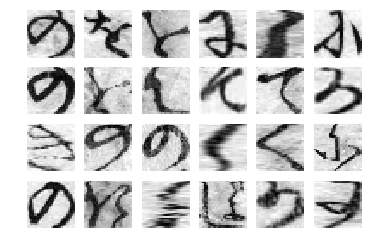

In [17]:
show_images()

In [7]:
train_x = np.reshape(train_x, (-1,28,28))

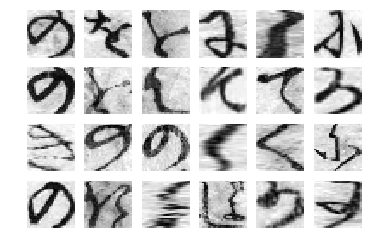

In [8]:
show_images()